In [1]:
%matplotlib inline
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from gravdark.stsp import STSP
from gravdark import hat7_params, LightCurve, concatenate_light_curves

In [2]:
h7_path = glob('/Users/bmmorris/data/gravdark/hat7/*slc.fits')
h7_lc_whole = LightCurve.from_raw_fits(h7_path, name='HAT-P-7 b')

h7_masked = LightCurve(**h7_lc_whole.mask_out_of_transit(hat7_params(), oot_duration_fraction=0.5))
h7_transits = h7_masked.get_transit_light_curves(hat7_params())
for transit in h7_transits:
    transit.remove_linear_baseline(hat7_params())
h7 = concatenate_light_curves(h7_transits)

params = hat7_params()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:849: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:850: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:374: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:375: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an er

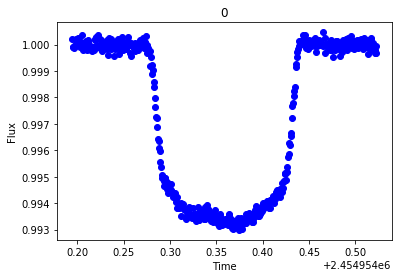

In [3]:
h7 = h7_transits[0]

h7.plot()

In [4]:
[0.1, np.radians(90+23), np.radians(0.01)]

[0.1, 1.9722220547535925, 0.00017453292519943296]

In [5]:
for attr in dir(params):
    if not attr.startswith('_'):
        print(attr, getattr(params, attr))

a 4.1545
b 0.49723805
duration 0.16430159
ecc 0.0
fp None
inc 83.143
inc_stellar 83.143
lam 0
limb_dark quadratic
per 2.2047354
per_rot 2.2047354
rp 0.07754991940679243
t0 2454954.35853331
t_secondary None
u [0.3492, 0.1733]
w 1.5707963267948966


<Container object of 3 artists>

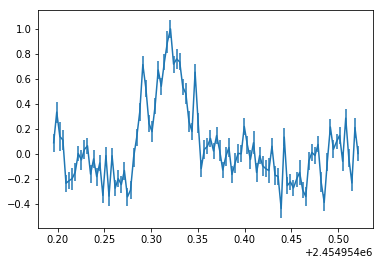

In [6]:
x, y, error = np.loadtxt("data/residuals.txt", unpack=True)

h7 = LightCurve(times=(x*params.per+params.t0), fluxes=y/y.max(), errors=error/y.max()/2)

plt.errorbar(h7.times.jd, h7.fluxes, h7.errors)

$$ s/r = \theta $$

At equator:
$$ C = 2\pi R_\star = N 2 (1+\epsilon) r_{spot} $$ 
$$ N = \frac{\pi R_\star}{(1+\epsilon)r_{spot}}$$

At latitude $\theta$, $R_{lat} = \sin{\theta}$

$$ N = \frac{\pi \sin{\theta}}{(1+\epsilon)r_{spot}}$$



In [19]:
ang_sep = 2*np.pi /(19 + 1)

19 * ang_sep

5.969026041820607

In [179]:
from itertools import chain

def angular_distance(theta_test, phi_test, thetas, phis):
    lon1 = phi_test
    lat1 = np.pi - theta_test
    lon2 = phis
    lat2 = np.pi - thetas
    return np.arccos(np.sin(lat1) * np.sin(lat2) + 
                     np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2))

# def fill_bands(theta_min, theta_max, phi_min=0, phi_max=2*np.pi, radius=0.02):
# #     theta_min = np.radians(90-10)
# #     theta_max = np.radians(90-20)
# #     phi_min = 0
# #     phi_max = 2*np.pi
# #     radius = 0.1
#     buffer_space = 1.2
#     phis = np.array([])
#     thetas = np.array([])
#     n_failed_tries = 0
#     n_samples = 30
#     while n_failed_tries < 10000 and len(phis) < n_samples: # len(phis) < n_samples and 
#         theta_rand = (theta_max - theta_min) * np.random.rand() + (theta_min)
#         phi_rand = (phi_max - phi_min) * np.random.rand() + phi_min
        
#         if len(phis) > 0:
# #             if np.all(np.sqrt((theta_rand - thetas)**2 + (phi_rand - phis)**2) > buffer_space*radius):
#             if np.all(angular_distance(theta_rand, phi_rand, thetas, phis) > buffer_space*2*radius):
#                 phis = np.append(phis, phi_rand)
#                 thetas = np.append(thetas, theta_rand)
#             else:
#                 n_failed_tries += 1

# #             if np.all(np.sqrt(((np.pi - theta_rand) - thetas)**2 + (phi_rand - phis)**2) > buffer_space*radius):
#             if np.all(angular_distance(np.pi - theta_rand, phi_rand, thetas, phis) > buffer_space*2*radius):
#                 phis = np.append(phis, phi_rand)
#                 thetas = np.append(thetas, np.pi - theta_rand)       

#         else: 
#             phis = np.append(phis, phi_rand)
#             thetas = np.append(thetas, theta_rand)

#             phis = np.append(phis, phi_rand)
#             thetas = np.append(thetas, np.pi - theta_rand)
#     return phis, thetas

def fill_bands(theta_min, theta_max, phi_min=0, phi_max=2*np.pi, radius=0.05):
    buffer_space = 1.2
    phis = np.array([])
    thetas = np.array([])
    n_failed_tries = 0
    n_samples = 30
    
    n_spots_per_lat = np.floor(np.pi * np.sin(theta_min) / (buffer_space * radius))
    
    long_sep = 2*np.pi / (n_spots_per_lat + 1)
    
    phis = np.arange(0, 2*np.pi, long_sep)[::2] + long_sep/2
    thetas = theta_min * np.ones_like(phis)
    
    phis = np.concatenate([phis, phis])
    thetas = np.concatenate([thetas, np.pi - thetas])
    
#     plt.figure()
#     plt.scatter(phis, thetas)
#     plt.xlabel('$\phi$')
#     plt.ylabel('$\theta$')
    return phis, thetas
    

def gaussian(p, x):
    amp, t0, sig = p
    return np.exp(-0.5 * (t0 - x)**2/sig**2)

def chi2(max_residuals):
    return np.sum((max_residuals/max_residuals.max() - 
                   h7.fluxes)**2/h7.errors**2) / (len(h7.fluxes) - 1)

def rtp_to_spotparams(radii, thetas, phis):
    return np.vstack([radii, thetas, phis]).T.reshape(-1)

def compute_max_residuals(lat, inc_stellar, lam): #, delta_longitude=30):
    params.inc_stellar = inc_stellar
    params.lam = lam
    max_residuals = np.zeros(h7.times.jd.shape)

#     for lon_offset in [0, delta_longitude/2]:
#         phis = np.arange(1, 360, delta_longitude) + lon_offset
#         theta_upper = np.radians(90 - lat)
#         theta_lower = np.radians(90 + lat)

#         spot_radius = 0.05
#         spot_params = list(chain(*[[spot_radius, theta_upper, np.radians(phi)] 
#                                     for phi in phis]))
#         spot_params.extend(list(chain(*[[spot_radius, theta_lower, np.radians(phi)] 
#                                          for phi in phis])))

    radius = 0.08
    phis, thetas = fill_bands(np.radians(90-lat-5), np.radians(90-lat+5), radius=radius)
    radii = np.ones_like(phis) * radius

    #print(len(spot_params)//3)
    for lon_offset in [0, 0.08]:
        spot_params = rtp_to_spotparams(radii, thetas, phis + radius/2)

        with STSP(h7, params, spot_params, keep_dir=True) as stsp:
            lc = stsp.stsp_lc(verbose=False, n_ld_rings=5)
            residuals = lc.fluxes - lc.transit_model(params)
            max_residuals = np.max(np.vstack([max_residuals, residuals]).T, axis=1)
    return max_residuals

def model(lat, inc_stellar, lam):
    max_residuals = compute_max_residuals(lat, inc_stellar, lam)
    return chi2(max_residuals)

[lund 2014](https://www-aanda-org.offcampus.lib.washington.edu/articles/aa/pdf/2014/10/aa24326-14.pdf)

In [165]:
np.degrees(0.08)

4.5836623610465859

In [166]:
lat = 20
phis, thetas = fill_bands(np.radians(90-lat-5), np.radians(90-lat+5), radius=0.1)

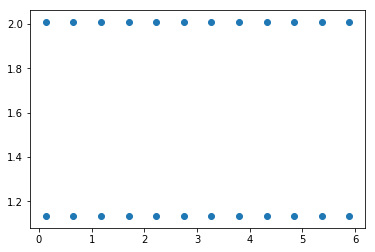

In [167]:
plt.scatter(phis, thetas)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


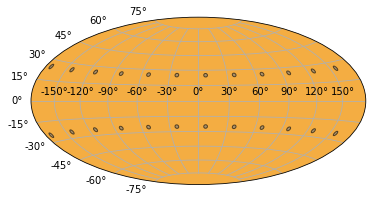

In [168]:
from astroML.plotting import plot_tissot_ellipse

ax = plt.subplot(111, projection='hammer')
ax.axes.set_axis_bgcolor('#f4ad42')
radius = 0.03
for longitude, latitude in zip(phis - np.pi, thetas - np.pi/2):
    p = plot_tissot_ellipse(longitude, latitude, 2*radius, ax=ax, facecolor='gray', 
                            edgecolor='k', lw=1, alpha=0.6)
ax.grid()

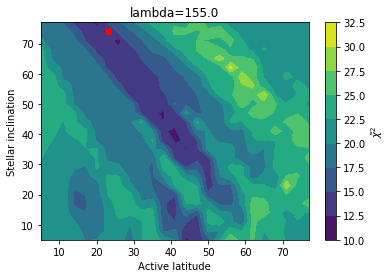

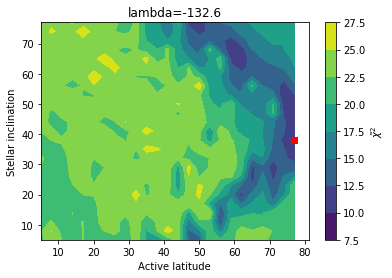

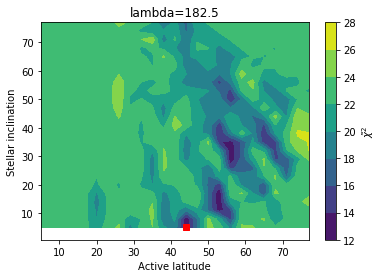

In [180]:
from astropy.utils.console import ProgressBar

test_latitudes = np.arange(5, 80, 3)
test_inc_stellars = np.arange(5, 80, 3)
lams = [155, -132.6, 182.5]
n_iters = len(test_latitudes) * len(test_inc_stellars)

for lam in lams:
    chi2s = []
    with ProgressBar(n_iters, ipython_widget=True) as bar:
        for test_lat in test_latitudes:
            #print('lat:', test_lat)
            chi2_lat = []
            for test_inc in test_inc_stellars:
                bar.update()
                #print('inc:', test_inc)
                chi2_lat.append(model(test_lat, test_inc, lam))
            chi2s.append(chi2_lat)
    chi2s = np.array(chi2s).reshape((test_latitudes.shape[0], test_inc_stellars.shape[0])).T

    minchi2 = np.unravel_index(np.nanargmin(chi2s), chi2s.shape)
    X, Y = np.meshgrid(test_latitudes, test_inc_stellars)

    best_lat, best_inc = test_latitudes[minchi2[1]], test_inc_stellars[minchi2[0]]
    cax = plt.contourf(X, Y, chi2s)
    plt.scatter(best_lat, best_inc, marker='s', color='r')
    plt.xlabel('Active latitude')
    plt.ylabel('Stellar inclination')
    plt.colorbar(cax, label=r'$\tilde{\chi}^2$')
    plt.title('lambda={0:.1f}'.format(lam))
    plt.show()

In [ ]:
# minchi2 = np.unravel_index(np.nanargmin(chi2s), chi2s.shape)
# X, Y = np.meshgrid(test_latitudes, test_inc_stellars)

# best_lat, best_inc = test_latitudes[minchi2[1]], test_inc_stellars[minchi2[0]]
# cax = plt.contourf(X, Y, chi2s)
# plt.scatter(best_lat, best_inc, marker='s', color='r')
# plt.xlabel('Active latitude')
# plt.ylabel('Stellar inclination')
# plt.colorbar(cax, label='$\chi^2$')

In [ ]:
# params.lam = -132.6
# params.inc_stellar = 35

# delta_longitude = 5
# for lon in np.arange(0, 360, delta_longitude):
#     with STSP(h7, params, [0.1, np.radians(15), np.radians(lon)]) as stsp:
#         lc = stsp.stsp_lc(verbose=False)
#         plt.plot(lc.times.jd, lc.fluxes - lc.transit_model(params), color='k')
# plt.plot(lc.times.jd, observed_residuals*0.00175, 'r')

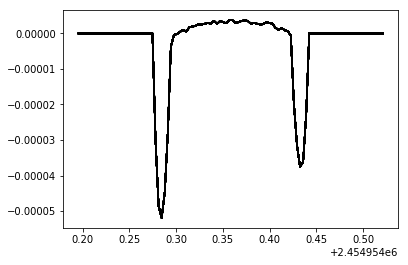

In [184]:
params.lam = 155
params.inc_stellar = 75

delta_longitude = 5
for lon in np.arange(0, 360, delta_longitude):
    with STSP(h7, params, [0.1, np.radians(20), np.radians(lon)]) as stsp:
        lc = stsp.stsp_lc(verbose=False)
        plt.plot(lc.times.jd, lc.fluxes - lc.transit_model(params), color='k')
#plt.plot(lc.times.jd, observed_residuals*0.00175, 'r')

In [ ]:
len(spot_params)//3

In [ ]:
params.lam = 155
params.inc_stellar = 75

delta_longitude = 10
# for lon in np.arange(0, 360, delta_longitude):
#     with STSP(h7, params, [0.1, np.radians(90-50), np.radians(lon)]) as stsp:
#         lc = stsp.stsp_lc(verbose=False)

lat = 25

for lon_offset in [0, delta_longitude/2]:
    phis = np.radians(np.arange(1, 360, delta_longitude) + lon_offset)
    theta_upper = np.radians(90 - lat)
    theta_lower = np.radians(90 + lat)

    spot_params = list(chain(*[[0.05, theta_upper, phi] for phi in phis]))
    #print(len(spot_params)//3)
    #spot_params.extend(list(chain(*[[0.1, theta_lower, phi] for phi in phis])))
    with STSP(h7, params, spot_params) as stsp:
        lc = stsp.stsp_lc(verbose=False)
        model_residuals = lc.fluxes - lc.transit_model(params)
        plt.plot(lc.times.jd, model_residuals/model_residuals.max(), color='k')
plt.errorbar(h7.times.jd, h7.fluxes, h7.errors/2)
plt.show()

In [ ]:
params.lam = -132.6
params.inc_stellar = 65

delta_longitude = 10
# for lon in np.arange(0, 360, delta_longitude):
#     with STSP(h7, params, [0.1, np.radians(90-50), np.radians(lon)]) as stsp:
#         lc = stsp.stsp_lc(verbose=False)

lat = 65

for lon_offset in [0, delta_longitude/2]:
    phis = np.radians(np.arange(1, 360, delta_longitude) + lon_offset)
    theta_upper = np.radians(90 - lat)
    theta_lower = np.radians(90 + lat)

    # spot_params = list(chain(*[[0.05, theta_upper, phi] for phi in phis]))
    # spot_params.extend(list(chain(*[[0.1, theta_lower, phi] for phi in phis])))
    with STSP(h7, params, spot_params) as stsp:
        lc = stsp.stsp_lc(verbose=False)
        model_residuals = lc.fluxes - lc.transit_model(params)
        plt.plot(lc.times.jd, model_residuals/model_residuals.max(), color='k')
plt.errorbar(h7.times.jd, h7.fluxes, h7.errors/2)
plt.show()

In [ ]:
np.vstack([np.arange(10), np.arange(10) + 50, np.arange(10) + 100]).T.reshape(-1)